In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/francesco/Desktop/Integrated Actin/virtual_lab')

In [2]:
from virtual_lab.experiments import *
from virtual_lab.simulation import *
from virtual_lab.model import *
from virtual_lab.utils import *
Sim = Simulation()

Initializing a simulation without a given model, a model should be added before running any experiment by calling Simulation.add_model()


## Structure -> How this script should look:
1. Initialize all the models
2. Show the equations for each (you have to implement the `__repr__` method)
3. Basic experiments for each + comparison
4. Comparison of STC experiments for each
5. Comparison of metaplasticity experiments for each

In [3]:
#TODO : Add 0.2 Hz experiments

# Trying out different models

## Model with normal $V_d$ non linearity and $V_n$

In [4]:
class BaseModel(Model):
    def diff_equations_dict(self):
        #super().list_of_equations(variables)
        needed_variables = ["Vd","Vs","Vpsd"]
        for name in needed_variables:
            if not name in self.variables.varnames:
                raise ValueError(f"The variable {name} is needed for this model, but was not given at initialisation")
        return {
            "Vd": self.dVd,
            "Vs": self.dVs,
            "PSD_95": self.dPSD,
            "Vpsd": self.dPSD
        }
    def equations_dict(self):
        needed_variables = ["V_n"]
        for name in needed_variables:
            if not name in self.variables.varnames:
                raise ValueError(f"The variable {name} is needed for this model, but was not given at initialisation")
        return {
            "V_n": self.V_n_calc,
            "V_tot": self.V_tot_calc
        }

    def initialise_variables(self,stochastic_model):
        self.eql  = self.k_u_0/self.k_b_0 / (1+self.k_u_0/self.k_b_0)
        self.eql2  = self.k_u_1/self.k_b_1 / (1+self.k_u_1/self.k_b_1)
        if not stochastic_model:
            self.variables.V_n = self.nu*self.nf_0*self.tau_Vd + self.variables.Vpsd 
            self.V_n_0 = self.variables.V_n
        else:
            self.variables.V_n = self.variables.Vpsd
            # This is a bit of a cheat, but I'll check if without this it still works.
            # TODO: check!
            self.nf_0 = np.mean(self.nf)
        self.variables.Vd =  self.eql    * self.variables.V_n
        self.variables.Vs = (1-self.eql) * self.variables.V_n
        self.Vd_0 = self.variables.Vd 
        self.variables.V_tot = self.variables.Vs + self.variables.Vd
    
    def quantity_dependencies(self):
        needed_quantities = ["k_u_1","k_b_1","nf_LTD","nf_LTP"]
        for q in needed_quantities:
            if not hasattr(self,q):
                raise AttributeError(f"The following quantity is not defined in the model, but it is needed by the experimental procedure {q}\n"
                "Make sure you define all the needed constants before running a simulation")
        dependencies = {
            "k_u": {"xlinkers": self.k_u_1},
            "k_b": {"xlinkers": self.k_b_1},
            "protein": {"protein": np.exp(-(np.arange(0,PROTEIN,self.dt))/3600)},
            "nf": {"stim": self.nf_LTP,
                     "LFS": self.nf_LTD},
            "gamma": {"stim": self.g_mul_LTP*self.gamma_0,
                      "LFS": self.g_mul_LTD*self.gamma_0},
            "mu" : {"stim": self.m_mul_LTP*self.mu_0,
                    "LFS": self.m_mul_LTD*self.mu_0}
        }
        return dependencies
    
    def stochastic_variables_dict(self):
        stochastic_variables = {
            "nf" : (bd_process,["gamma","mu"])
        }
        return stochastic_variables
            
    def termalization_step(self,t):
        Vd_tmp = self.model.dVd( t) 
        # Vs grows and shrinks through x-linker binding and unbinding
        Vs_tmp = self.model.dVs(t)
        return Vd_tmp,Vs_tmp

    def dVd(self,t): # Vd with V-dependent removal: Dynamic pool shrinks if V>PST_str, Growth with number of foci 
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        Vpsd = self.variables.Vpsd
        return self.nu*self.nf[t]*(Vd/self.Vd_0)**self.AFB  - (Vd+Vs-Vpsd)/self.tau_Vd*(Vd/self.Vd_0)**self.DVD  - self.k_b[t]*Vd + self.k_u[t] *Vs
    
    def dVs(self,t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        return self.k_b[t]*Vd - self.k_u[t] *Vs 

    def dPSD(self,t):
        if self.dynamicPSD == 0:
            Vs = self.variables.Vs
            Vd = self.variables.Vd
            Vpsd = self.variables.Vpsd
            V_n = self.variables.V_n
            PSD = self.protein[t]*(Vd+Vs - V_n)/self.tau_PSD_mol
            return PSD
        if self.dynamicPSD == 1:
            Vs = self.variables.Vs
            Vd = self.variables.Vd
            V_n = self.variables.V_n
            Vpsd = self.variables.Vpsd
            PSD_95 = self.variables.PSD_95
            V = (Vd+Vs - V_n)/self.tau_PSD_mol + (PSD_95-Vpsd)/self.tau_adaptation
            PSD = self.protein[t]*(Vpsd-PSD_95)/self.tau_adaptation
            return PSD,V

    def V_n_calc(self,t,**kwargs):
        PSD = kwargs.get('attractor',self.variables.Vpsd)
        pre = PSD*self.k_u_0
        root = self.k_u_0*(4*self.Vd_0*self.nu*self.nf_0*self.tau_Vd*(self.k_u_0 + self.k_b_0)+self.k_u_0*PSD**2)
        root = np.sqrt(root) if root>0 else 0
        den = 2*self.k_u_0
        return (pre + root)/den
        # return self.nu*self.nf_0*self.tau_Vd + self.variables.Vpsd
    
    def V_tot_calc(self,t):
        return self.variables.Vd + self.variables.Vs

In [5]:
# Making the constants optimal for this model
const_base = CONSTANTS.copy()
const_base["tau_Vd"] = 5400
base_model = BaseModel("Base", {"Vd":None,"Vs":None,"Vpsd":1,"V_n":None,"V_tot":None,"PSD_95":1},const = const_base)
Sim.add_model(base_model)

Switching to model Base


## Momentum Model -> A bit of a monster

So, this I can make work pretty well with the addition of a few extra parameter changes (one for enlarging the synapse, and one for the shrinkage). Biophysically, they're both plausible as they could account for the concentration of dephosphorylated cofilin in the synapse. In that case, the balance between polymerization and depolymerization is shifted. This could be introduced in the $V_d$ variable, but that would still not reproduce the complex STC experiments, which with this model we can do. One thing to look up is how long the dephosphorylated cofilin is present in large amounts during LTD.

MAYBE: You could define $V_e$ as the volume of the synapse in equilibrium (no nucleation), given a certain concentration of d-cofilin vs p-cofilin. This is the attractor for the stable and dynamic pool due to physical forces (as in Bonilla-Quintana-Fauth), and its value shifts depending on environmental conditions.. Currently, the concentration is given as $c_d$ and it increases quadratically after a stimulus (be it HFS or LFS). I have no clue if this is accurate, out of the few variations I implemented this seems to work the best. Anyways, the behavior of this $V_e$ seems to make sense with what the enlargement pool is supposed to do during LTP. This doesn't mean that $V_e$ is the actual volume of the enlargement pool, though, and here's the tricky part. You could imagine $V_e$ to be the unbalance between how much actin is being cut vs how much the synapse can use the recently cut actin to form new filaments. If the volume of the synapse is enlarged, then we have space to actually grow the enlargement which will stabilize the volume, and $V_e$ increases. If instead the volume is small, then we don't have enough actin to form the new pool, and the excess cofilin is instead only devoted to cutting the already present pools, and we have an overall decrease in the ability to keep up with the membrane forces that tend to make the synapse implode.  

In [6]:
class MomentumModel(BaseModel):
    def diff_equations_dict(self):
        _dict = super().diff_equations_dict()
        needed_variables = ["Ve"]
        for name in needed_variables:
            if not name in self.variables.varnames:
                raise ValueError(f"The variable {name} is needed for this model")
        _dict["Ve"] = self.dVe
        _dict.pop("PSD_95")
        return _dict
    
    def initialise_variables(self,stochastic_model):
        super().initialise_variables(stochastic_model)
        self.variables.Ve = self.variables.Vpsd
    
    def quantity_dependencies(self):
        _dict = super().quantity_dependencies()
        _dict["c_d"] = {"enlargement": 1,
                        "shrinkage": 1 }
        return _dict
    
    def dVd(self, t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        Vpsd = self.variables.Vpsd
        Ve = self.variables.Ve
        return self.nu*self.nf[t]*(Vd/self.Vd_0)**self.AFB  - (Vd+Vs-Ve)/self.tau_Vd*(Vd/self.Vd_0)  - self.k_b[t] *Vd  + self.k_u[t] *Vs
 
    def dVe(self,t):
        V_tot = self.variables.V_tot
        V_n = self.variables.V_n
        Ve = self.variables.Ve
        Vd = self.variables.Vd
        Vpsd = self.variables.Vpsd
        return (self.c_d[t])*(V_tot - V_n)/(self.tau_add_Ve) + (Vpsd - Ve)/self.tau_Ve
    
    def dPSD(self,t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        V_n = self.variables.V_n
        Ve = self.variables.Ve
        Vpsd = self.variables.Vpsd
        PSD = self.protein[t]*(Ve - Vpsd)/self.tau_PSD_mol
        return PSD
    
    def V_n_calc(self, t):
        return super().V_n_calc(t,attractor = self.variables.Ve)

BasicExperiments.add_event("enlargement",[E_ONSET,X_ENLARGE],concurrence = "stim")
BasicExperiments.add_event("shrinkage",[E_ONSET,X_ENLARGE],concurrence = "LFS")

In [7]:
# Optimizing constants for this model
const_momentum = CONSTANTS.copy()
enlarge_dict = {# Enlargement pool
    "k_e_0" : 0,
    "k_e_1" : 1,
    "tau_add_Ve": 120, #120
    "tau_Ve": 7200,
    # Dynamic pool timescale
    "tau_Vd": 3000}
const_momentum.update(enlarge_dict)
mom_model = MomentumModel("Momentum",{"Vd": None, "Vs": None, "Vpsd": 1., "V_n": None,"V_tot": None,"Ve": None}, const = const_momentum)
Sim.add_model(mom_model,switching=False)

## Model with 1/PSD non-linearity

In [8]:
class PSDNonLinearModel(BaseModel):
    def diff_equations_dict(self):
        _dict = super().diff_equations_dict()
        _dict["Vpsd"] = self.dVpsd
        return _dict
    
    def dPSD(self,t):
        Vpsd = self.variables.Vpsd
        PSD_95 = self.variables.PSD_95
        return (Vpsd - PSD_95)/self.tau_adaptation
    
    def dVpsd(self,t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        V_n = self.variables.V_n
        Vpsd = self.variables.Vpsd
        PSD_95 = self.variables.PSD_95
        return self.protein[t] * (Vd + Vs - Vpsd*V_n/PSD_95)/self.tau_PSD_mol + (PSD_95-Vpsd)/self.tau_adaptation
    
    def V_n_calc(self, t):
        return self.nu*self.nf_0*self.tau_Vd + self.variables.Vpsd

In [9]:
# Taking care of the constants, to make the model more effective
const_composite_PSD = CONSTANTS.copy()
dict_update = {
    "tau_Vd": 5400,
    "tau_PSD_mol": 300
}
const_composite_PSD.update(dict_update)
PSDModel = PSDNonLinearModel("PSDNonLinearity", {"Vd":None,"Vs":None,"Vpsd": 1,"V_n": None,"V_tot": None,"PSD_95": 1},const = const_composite_PSD)
Sim.add_model(PSDModel,switching=False)

# Basic Experiments & Comparison

Termalizing...
stochastic process run..
Termalized
Simulating 13 experiments took: 29.445 s
Plotting 13 experiments


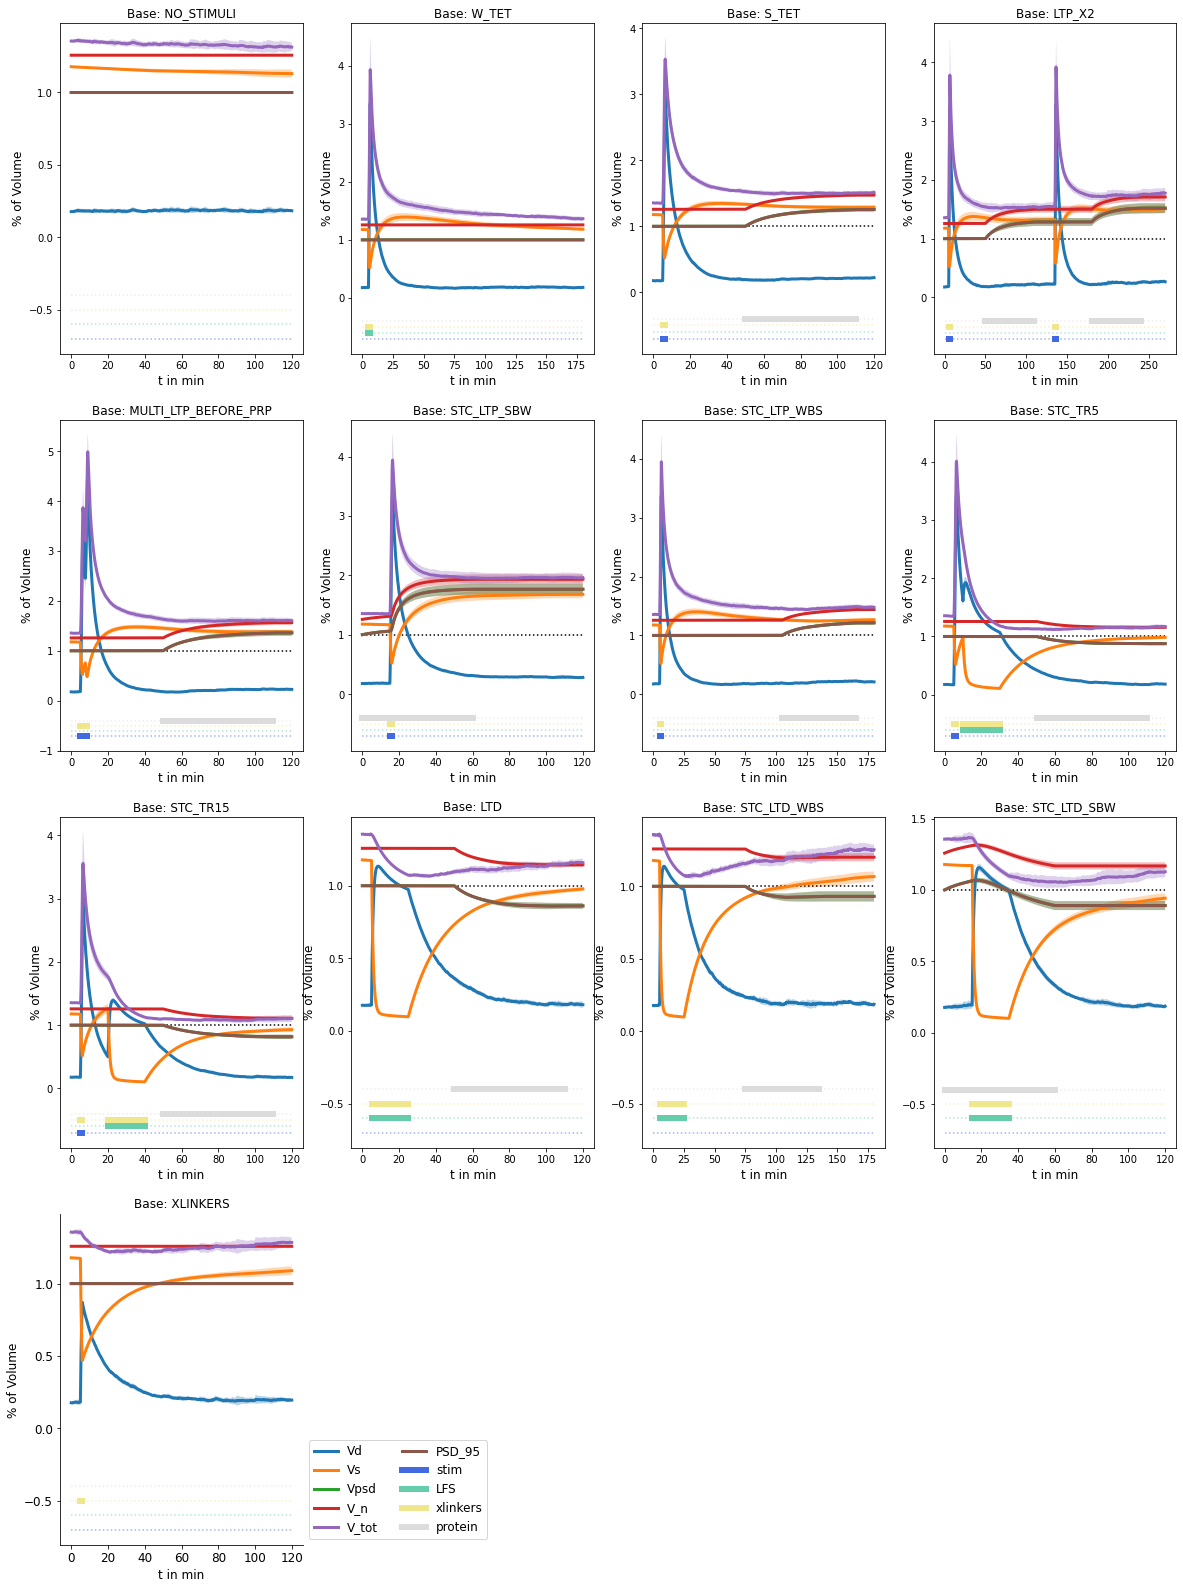

Termalizing...
stochastic process run..
Termalized
Simulating 13 experiments took: 25.747 s
Plotting 13 experiments


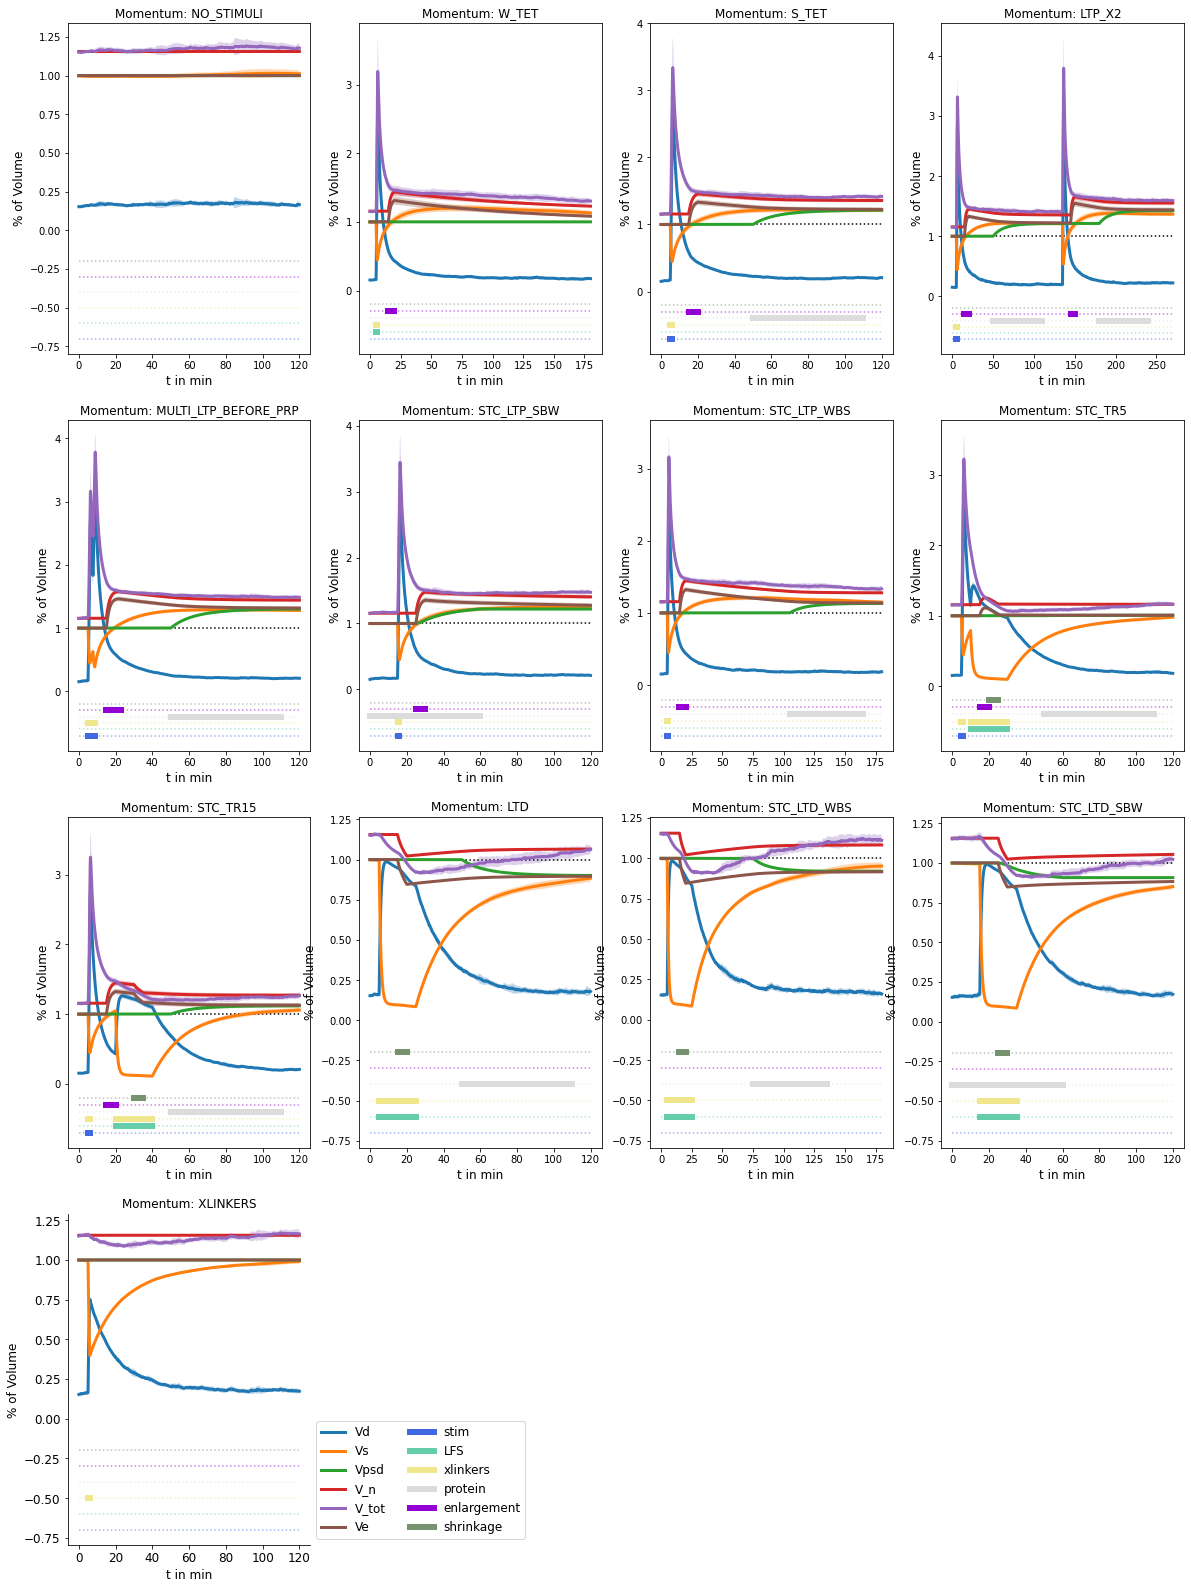

Termalizing...
stochastic process run..
Termalized
Simulating 13 experiments took: 22.581 s
Plotting 13 experiments


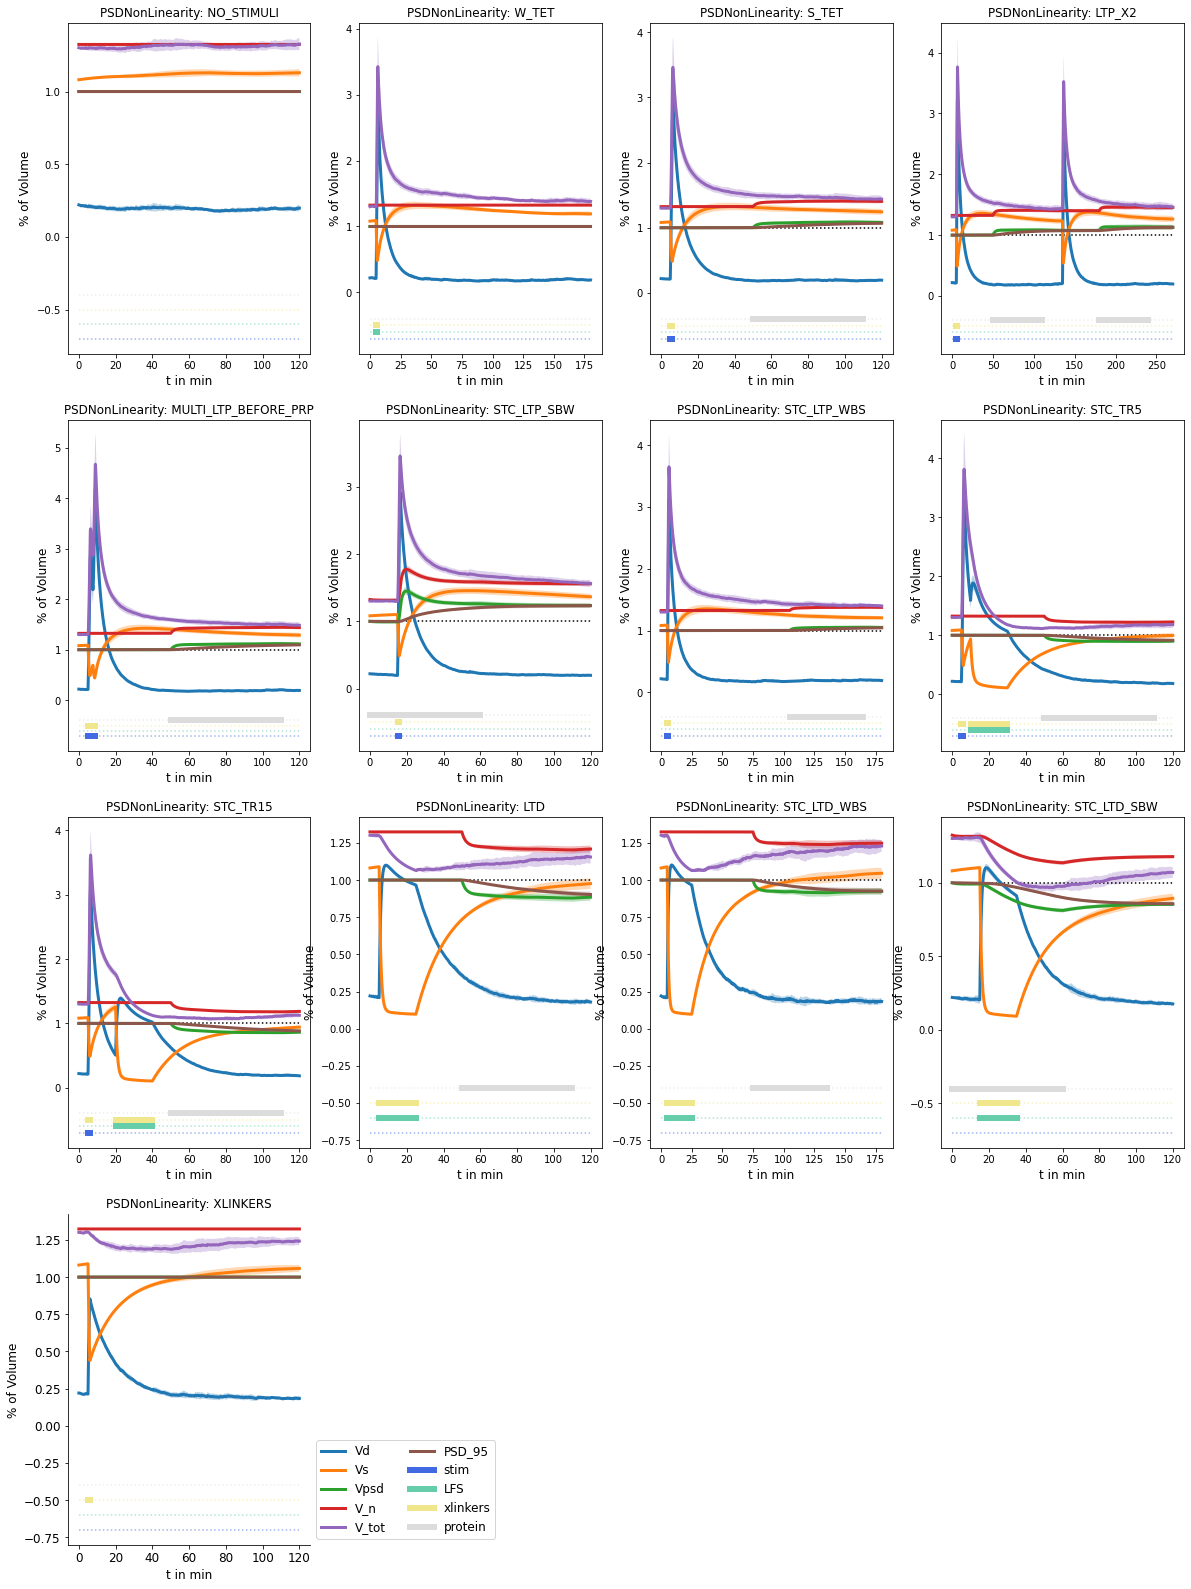

In [10]:
for model in Sim.models:
    Sim.switch_model(model)
    _ = Sim.run_experiments(BasicExperiments,n_of_runs=10,stochastic_model=True, termalize = True,termalization_time=5*3600,record_termalization=False)
    Sim.plot_volumes(name = f"{model}_base_exp.pdf")

Plotting 39 experiments


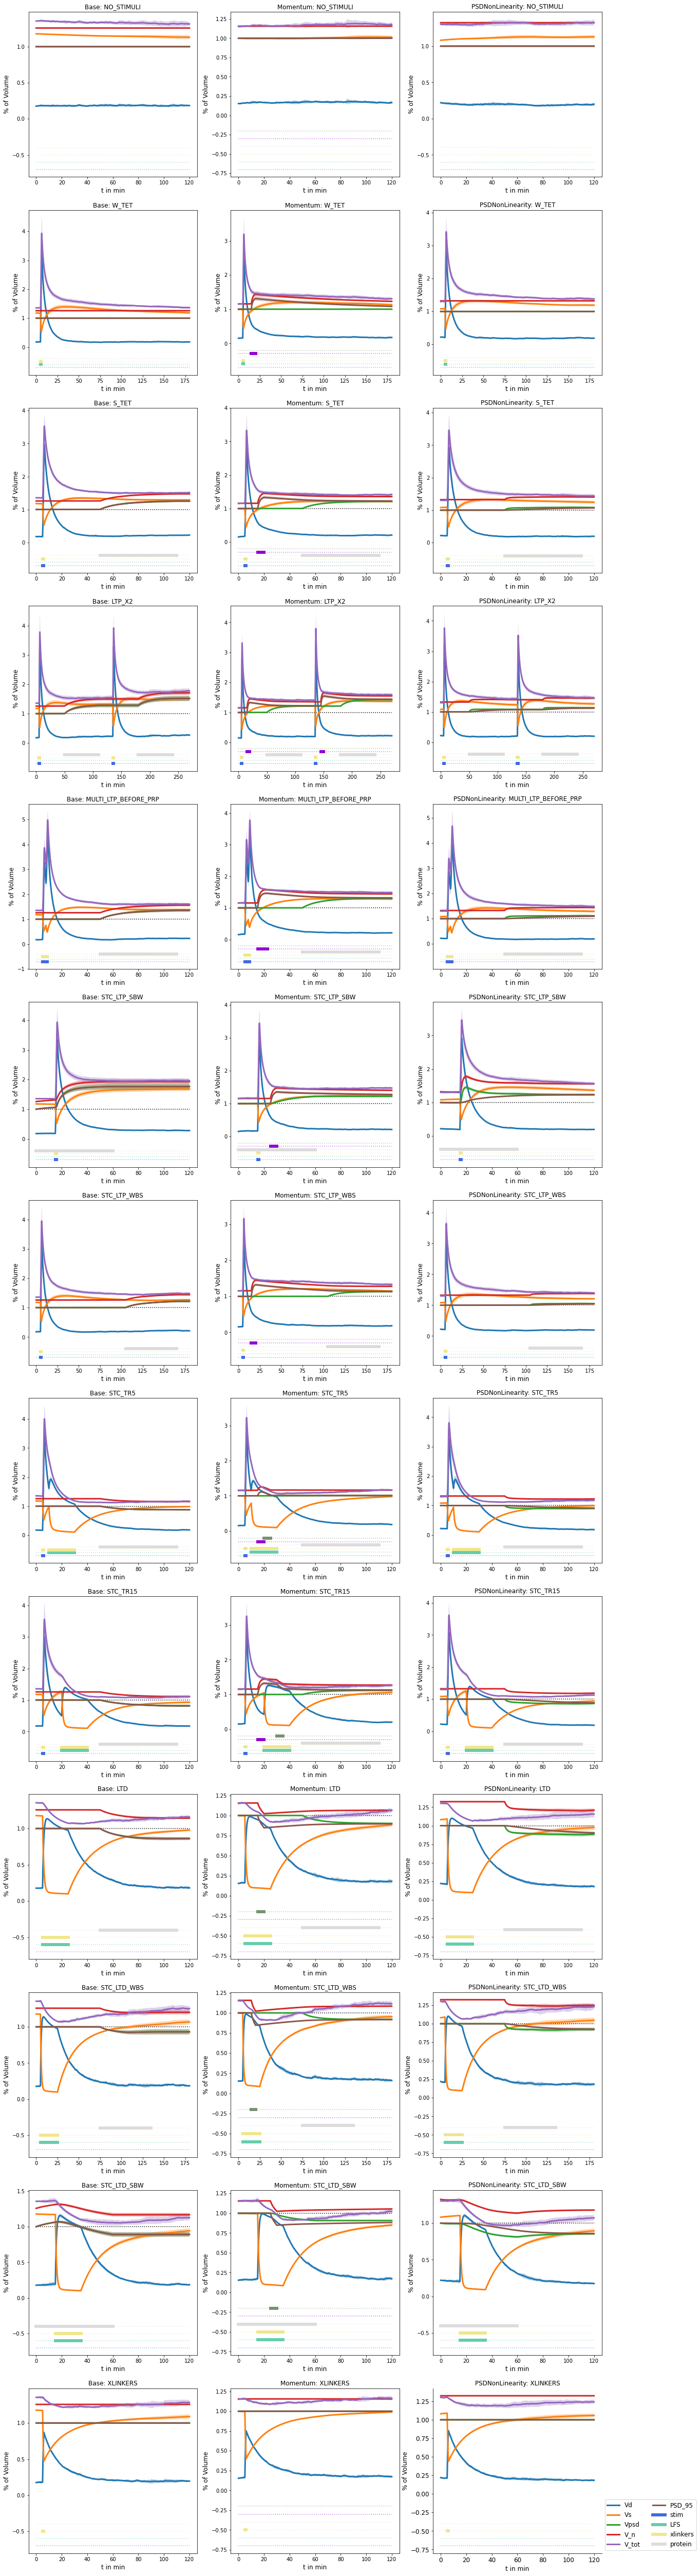

In [11]:
Sim.plot_comparison(name = "base_exp_comparison.pdf")

# Tag reset experiments comparison

In [12]:
Sim.models["Momentum"].stop_recording_variables(["Ve"])

{'Vd': True, 'Vs': True, 'Vpsd': True, 'V_n': True, 'V_tot': True, 'Ve': True}
{'Vd': True, 'Vs': True, 'Vpsd': True, 'V_n': True, 'V_tot': True, 'Ve': False}


In [13]:
TagResetExperiments.add_event("enlargement",[E_ONSET,X_ENLARGE],concurrence = "stim")
TagResetExperiments.add_event("shrinkage",[E_ONSET,X_ENLARGE],concurrence = "LFS")
do_not_record = {
    "Vd" : False,
    "Vs" : False,
    "V_n": False
}
# TODO allow for comparison of different model results!
for model in ["Momentum"]:
    Sim.models[model].stop_recording_variables(do_not_record)
    Sim.switch_model(model)
    tr_results = Sim.run_experiments(TagResetExperiments,save_results=False)
    x_data = [tr_results[i]["experiment"].LFS[0][0] -300 for i in range(len(tr_results))]
    # Take as reference the value of the PSD after potentiation
    reference_values = [Sim.model_results[model][2]["Vpsd"][-1],1]
    Sim.plot_selected_points(tr_results,"Vpsd","last",event_type="LFS", x_data = x_data, reference_values=reference_values,name = f"{model}_tag_resetting")

{'Vd': True, 'Vs': True, 'Vpsd': True, 'V_n': True, 'V_tot': True, 'Ve': False}
{'Vd': False, 'Vs': False, 'Vpsd': True, 'V_n': False, 'V_tot': True, 'Ve': False}
Simulating 22 experiments took: 0.673 s
Making 1 plots


c:\Users\franz\Desktop\Programming_stuff\Integrated Actin\virtual_lab\simulation.py:486: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("plots/" + name)
c:\Users\franz\miniconda3\envs\comphy\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 615x136893 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x432 with 1 Axes>

# Metaplasticity experiments and comparison

Simulating 3 experiments took: 7.084 s
Making 3 plots


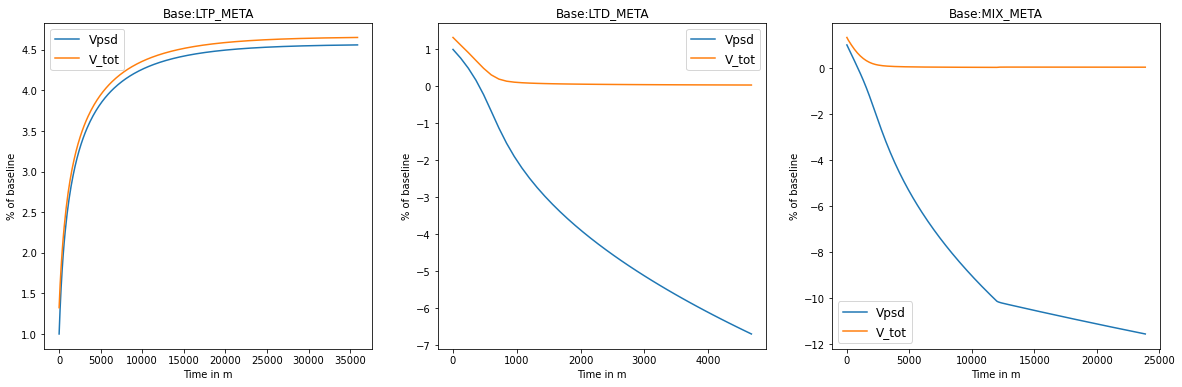

Simulating 3 experiments took: 7.675 s
Making 3 plots


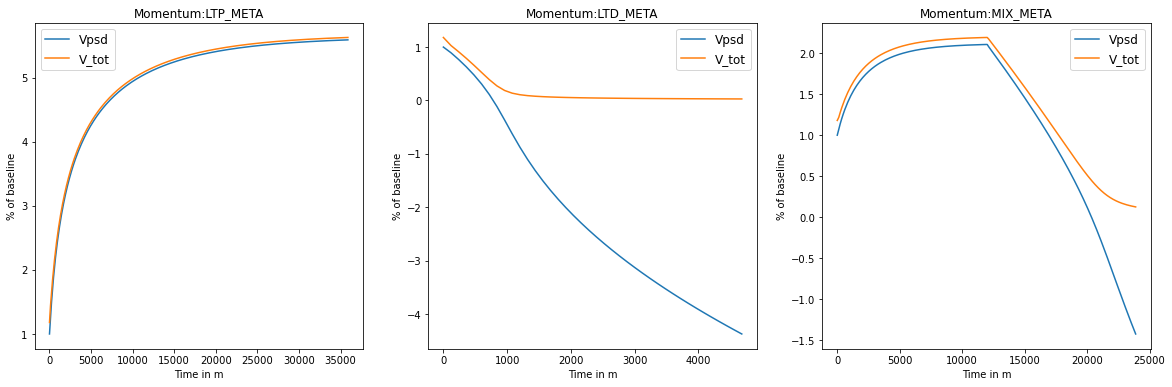

Simulating 3 experiments took: 5.788 s
Making 3 plots


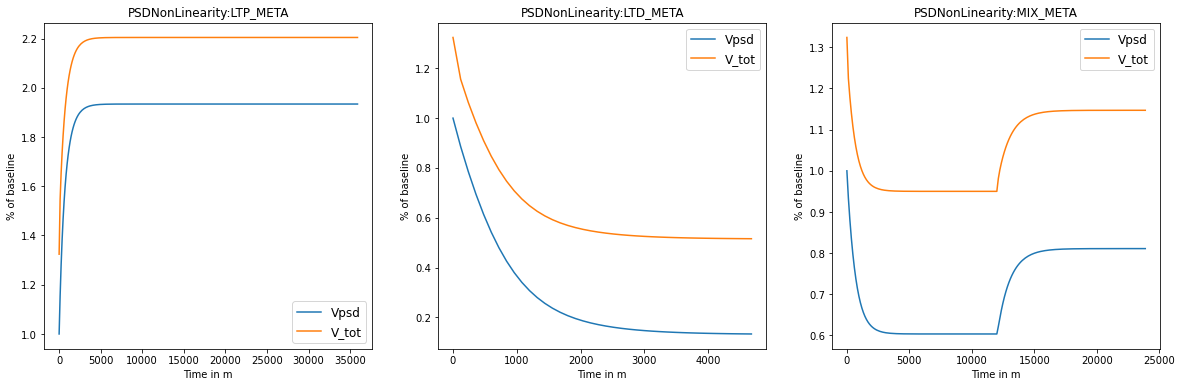

In [ ]:
MetaPlasticityExperiments.add_event("enlargement",[E_ONSET,X_ENLARGE],concurrence = "stim")
MetaPlasticityExperiments.add_event("shrinkage",[E_ONSET,X_ENLARGE],concurrence = "LFS")
for model in Sim.models:
    Sim.switch_model(model)
    meta_results = Sim.run_experiments(MetaPlasticityExperiments)
    Sim.plot_selected_points(meta_results,["Vpsd","V_tot"],"last_before_event",["stim","LFS"],name = f"{model}_metaplasticty.pdf")

The reason why metaplasticity for LTD doesn't work is because the difference between V_tot and Ve is shrinking as you increase the volume (the relative effect of nucleation decreases!) Maybe adapting the nucleation to the volume would result in a proper depression-metaplasticity. To do this I need to add complexity to the model, but at this point I don't even care anymore. 

To say it better, I will try to make a good model, no matter how complex, and then try to extract a minimal model from it which can reproduce the most results!

## Linear Model